# Setting up our Notebook

In [1]:
# Standard Imports
import matplotlib.pyplot as plt
import numpy as np
import string
import math
import random 

# Processing
from sklearn.decomposition import PCA

# Neural Nets
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow as tf2
from tensorflow import keras
print('Tensorflow Version',tf.__version__)

# NLP
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from collections import namedtuple # For Doc2Vec

# PDF manipulation
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

# Other
import collections
from scipy import spatial

Instructions for updating:
non-resource variables are not supported in the long term
Tensorflow Version 2.9.1


Another useful source: https://blog.paperspace.com/pre-trained-word-embeddings-natural-language-processing/

# Parameters and Needed Functions

In [2]:
# Parameters for our model

learning_rate = 1e-4; n_input = 4; 
n_hidden = 500; epochs = 300
offset=10; n_units = n_hidden

In [3]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2)/float(np.linalg.norm(v1)*np.linalg.norm(v2))

In [4]:
# Sample text we wish to add to our model

sample_text = '''Living in different places has been the greatest experience 
that I have had in my life. It has allowed me to understand people from 
different walks of life, as well as to question some of my own biases I have had 
with respect to people who did not grow up as I did. If possible, everyone should 
take an opportunity to travel somewhere separate from where they grew up'''.replace('\n', '')

In [5]:
# Parameters for our model

learning_rate = 1e-4; n_input = 4; 
n_hidden = 500; epochs = 300
offset=10; n_units = n_hidden

# Pretrained Embedding

In [6]:
# Loading the pre-trained embedding

def load_embedding(embedding_path='Data/glove.6B.50D.txt'):
    vocabulary, embedding, embedding_dictionary = [], [], {}
    for line in open(embedding_path, 'r', encoding="utf8").readlines():
        row = line.strip().split(' ')
        vocabulary.append(row[0]), embedding.append(row[1:])
        embedding_vector = [float(i) for i in row[1:]]
        embedding_dictionary[row[0]] = embedding_vector
    vocabulary_length, embedding_dim = len(vocabulary), len(embedding[0])
    return vocabulary, np.asarray(embedding, dtype=float), vocabulary_length, embedding_dim, embedding_dictionary


In [7]:
# Visualizing the pre-trained embedding

def visualize_embedding_example():
    
    vocabulary, embedding, vocabulary_length, embedding_dim, embedding_dictionary = load_embedding()
    # We run the above load_embedding function to give us information about the embedding we are adding to

    #Showing example of pretrained word embedding vectors
    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(embedding)
    plt.scatter(pca_embedding[0:50, 0], pca_embedding[0:50, 1])
    for i, word in enumerate(vocabulary[0:50]):
        plt.annotate(word, xy=(pca_embedding[i, 0], pca_embedding[i, 1]))
        
    #Comparing cosine similarity 
    for k in range(100, 105):
        text = str('Cosine Similarity Between %s and %s: %s')%(vocabulary[k],
                                                            vocabulary[k-1], 
                                                cosine_similarity(embedding[k], 
                                                                  embedding[k-1]))
        print(text)

Cosine Similarity Between so and u.s.: 0.5606769548631282
Cosine Similarity Between them and so: 0.8815159254335487
Cosine Similarity Between what and them: 0.8077565084355356
Cosine Similarity Between him and what: 0.7972281857691554
Cosine Similarity Between united and him: 0.5374600664967558


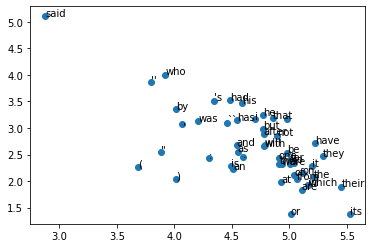

In [8]:
visualize_embedding_example()

In [9]:
vocabulary, embedding, vocabulary_length, embedding_dim, embedding_dictionary = load_embedding()

In [10]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print('embedding', embedding[0:5])
print('embedding dictionary', take(5, embedding_dictionary.items()))
print(embedding[26, :])

embedding [[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
  -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
  -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
  -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
  -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
   4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
   1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
  -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
  -1.1514e-01 -7.8581e-01]
 [ 1.3441e-02  2.3682e-01 -1.6899e-01  4.0951e-01  6.3812e-01  4.7709e-01
  -4.2852e-01 -5.5641e-01 -3.6400e-01 -2.3938e-01  1.3001e-01 -6.3734e-02
  -3.9575e-01 -4.8162e-01  2.3291e-01  9.0201e-02 -1.3324e-01  7.8639e-02
  -4.1634e-01 -1.5428e-01  1.0068e-01  4.8891e-01  3.1226e-01 -1.2520e-01
  -3.7512e-02 -1.5179e+00  1.2612e-01 -2.4420e-02 -4.2961e-02 -2.8351e-01
 

# Training

In [11]:
def training_data_example(vocabulary, embedding,
                          vocabulary_length, embedding_dim, embedding_dictionary,
                          sample_text=sample_text, learning_rate=learning_rate, 
                          n_input=n_input, n_hidden=n_hidden, epochs=epochs,
                          offset=offset, n_units=n_units):
                          
    _sample_text = np.array(sample_text.split())
    _sample_text = _sample_text.reshape([-1, ])
    print('Sample text', _sample_text)
    _sample_embedding_array = []

    def sample_text_dictionary(data=_sample_text):
        count, dictionary = collections.Counter(data).most_common(), {} # Creates list of word/count pairs;
        for word, _ in count:
            dictionary[word] = len(dictionary) # Len(dictionary) increases each iteration
            reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        dictionary_list = sorted(dictionary.items(), key = lambda x : x[1])
        return dictionary, reverse_dictionary, dictionary_list
        
    sample_dictionary, sample_reverse_dictionary, sample_dictionary_list = sample_text_dictionary()
    
    for i in range(len(sample_dictionary)):
        word = sample_dictionary_list[i][0]
        if word in vocabulary:
            _sample_embedding_array.append(embedding_dictionary[word])
        else:
            _sample_embedding_array.append(np.random.uniform(low=-0.2, high=0.2, size=embedding_dim))
            print('This word is not in the pretrained embedding dictionary:', word)
     
    sample_embedding_array = np.asarray(_sample_embedding_array)     
    decision_tree = spatial.KDTree(sample_embedding_array, leafsize=100)
    print('Sample dictionary', sample_dictionary)

    # Initializing placeholders and other variables

    X = tf.placeholder(tf.int32, shape=(None, None, n_input)) # We will fill this with x_train, a sequence of n_input words, later on
    # print('X', X, '\n')
    Y = tf.placeholder(tf.float32, shape=(None, embedding_dim)) # We will fill this with y_train later on
    # print('Y', Y, '\n')
    weights = {'output': tf.Variable(tf.random_normal([n_hidden, embedding_dim]))} # Random initial weights
    # print('weights', weights, '\n')
    biases = {'output': tf.Variable(tf.random_normal([embedding_dim]))} # Random initial biases
    # print('baises', biases, '\n')

    # Setting up the computational graph to update the pretrained embedding
    
    _weights = tf.Variable(tf.constant(0.0, shape=[vocabulary_length, embedding_dim]), trainable=True) # Weights which we will assign
    _embedding = tf.placeholder(tf.float32, [vocabulary_length, embedding_dim]) # We want to actually train our embedding
    embedding_initializer = _weights.assign(_embedding) # The weights are coming from the embedding
    embedding_characters = tf.nn.embedding_lookup(_weights, X) # This will give us the weights (which are the embeddings, from the line above)
    # of our X values (words) in each epoch from the embedding fed to the 'embedding_initializer'
        
    input_series = tf.reshape(embedding_characters, [-1, n_input])
    input_series = tf.split(input_series, n_input, 1) # Now we have the weights from the embedding of choice
    # which will be the pretrained, in this case, for each word

    # Creating our model

    lstm_cell =   tf2.keras.layers.LSTMCell(units=n_units, activation=tf.nn.relu) # LSTM cell
    outputs, states = tf.compat.v1.nn.static_rnn(lstm_cell, input_series, dtype=tf.float32) # Running the input through the LSTM cell
    # to get the outputs and states    
    output_layer = tf.add(tf.matmul(outputs[-1], weights['output']), biases['output']) # Getting y_hat using the weights and biases
    # calculated just after 'Initializing placeholders...'
    error = tf.reduce_mean(tf.nn.l2_loss(output_layer - Y)) # Error
    adam_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(error) # Optimization with Adam to optimize the
    # weights, biases, AND the pretrained weights (embedding)

    # Training 
    
    with tf.Session() as sess: # Running the training
        
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            
            if offset+n_input >= len(sample_reverse_dictionary): # Allowing us to train on random chunks of the training data (words)
                offset = random.randint(0, n_input+1)
                print('Hitting random offset', '\n')
           
            sess.run(embedding_initializer, feed_dict={_embedding: embedding}) # Setting the embedding as our pretrained one
            
            # Creating input and output training data
            x_train = [[sample_dictionary[str(_sample_text[i])]] for i in range(offset, offset+n_input)] # Creating random training set
            # of size n_input
            x_train = np.reshape(np.array(x_train), [-1, 1, n_input]) # Reshaping the training set
            # print('X_train', x_train, '\n')
            word = _sample_text[offset+n_input]
            word_index = sample_dictionary[word]
            y_train = sample_dictionary[_sample_text[offset+n_input]] # Getting the correct next word's index in the sample_dictionary
            y_train = embedding[y_train, :] # Getting the pretrained embedding at the index given in the previous line
            y_train = np.reshape(y_train, [1, -1])
            # print('y_train', y_train, '\n')
    
            _, _error, _prediction = sess.run([adam_optimizer, error, output_layer], 
                                     feed_dict = {X: x_train, Y: y_train})
            
            if epoch%10 == 0 and epoch > 0: # Checking how our NN is doing
                input_sequence = [str(_sample_text[i]) for i in range(offset, offset+n_input)] # Getting a sequence of words
                target_word = str(_sample_text[offset+n_input]) # Getting the correct word
                distance, _index = decision_tree.query(_prediction[0], 1) # Getting the predicted word's index using the sample_text
                # embedding
                predicted_word = sample_reverse_dictionary[_index] # Getting the predicted word
                  
                print('Input Sequence: %s \nActual Label: %s \nPredicted Label: %s'%
                      (input_sequence, target_word, predicted_word))
                print('Epoch: %s \nError: %s \n'%(epoch, _error))
                offset += (n_input+1) 

In [12]:
training_data_example(vocabulary, embedding, vocabulary_length, embedding_dim, embedding_dictionary)

Sample text ['Living' 'in' 'different' 'places' 'has' 'been' 'the' 'greatest'
 'experience' 'that' 'I' 'have' 'had' 'in' 'my' 'life.' 'It' 'has'
 'allowed' 'me' 'to' 'understand' 'people' 'from' 'different' 'walks' 'of'
 'life,' 'as' 'well' 'as' 'to' 'question' 'some' 'of' 'my' 'own' 'biases'
 'I' 'have' 'had' 'with' 'respect' 'to' 'people' 'who' 'did' 'not' 'grow'
 'up' 'as' 'I' 'did.' 'If' 'possible,' 'everyone' 'should' 'take' 'an'
 'opportunity' 'to' 'travel' 'somewhere' 'separate' 'from' 'where' 'they'
 'grew' 'up']
This word is not in the pretrained embedding dictionary: I
This word is not in the pretrained embedding dictionary: Living
This word is not in the pretrained embedding dictionary: life.
This word is not in the pretrained embedding dictionary: It
This word is not in the pretrained embedding dictionary: life,
This word is not in the pretrained embedding dictionary: did.
This word is not in the pretrained embedding dictionary: If
This word is not in the pretrained embeddi

Problem: It seems as if the way thsi algorithm is set up has us grabbing the index of the word from the sample_dictionary and then just using that index and getting the embedding from the pretrained embedding at the index and using that as our goal. But, there doesn't seem to be any relationship between the sample_dictionary keys/values and the pretrained embedding dictionary. Why are we doing this?